# Final Project: Used Car Price Predictor - Grid-Search and Model
### Author: Satish Agrawal, Sanjay Jaras
### Bellevue University
### DSC 630 - Predictive Analytics

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import seaborn as sns

### Notebook Configurations

In [2]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)
import warnings
warnings.filterwarnings('ignore')

### Load Processed Training Data from CSV

In [3]:
train_X = pd.read_csv("train_X.csv", index_col=[0])
train_Y = pd.read_csv("train_Y.csv", index_col=[0])

### Load Test Dataset from CSV

In [4]:
test_X = pd.read_csv("test_X.csv", index_col=[0])
test_Y = pd.read_csv("test_Y.csv", index_col=[0])

### Repeated Stratified K-Fold cross validator.

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)

### Preform Grid-serach with 50,000 records 
Program is crashing if we use all training set

In [6]:
param_grid = [
              {},
              {},
              {'learning_rate': [0.1, 0.3], 'max_depth':[10, 30], 'n_estimators':[50, 100, 150]},
              {'n_estimators':[100, 200, 300]},
              {'n_neighbors': [5, 20, 50]},
              {'alpha': [1, 10, 100], 'max_iter': [1000, 2000], 'tol':[0.001, 0.01, 0.1]},
              {'alpha': [1, 10, 100], 'max_iter': [1000, 2000], 'tol':[0.001, 0.01, 0.1]},
             ]
estimators = [
              LinearRegression(),
              DecisionTreeRegressor(random_state=random_state),
              XGBRegressor(gpu_id=0, objective='reg:squarederror'),
              RandomForestRegressor(random_state=random_state),
              KNeighborsRegressor(), 
              Ridge(random_state=random_state),
              Lasso(random_state=random_state),
             ]
grid_result = []
for i in tqdm(range(len(estimators))):
    print( "*" * 100)
    print("Evaluating Model", estimators[i].__class__.__name__)
    grid_reg = GridSearchCV(estimators[i], param_grid=param_grid[i], cv=cv, verbose=10, n_jobs=13, scoring="r2")
    grid_reg.fit(train_X.head(50_000), train_Y.head(50_000).to_numpy().ravel())
    print("Best Score:", grid_reg.best_score_)
    print("Best Params:", grid_reg.best_params_)
    grid_result.append(grid_reg)

  0%|          | 0/7 [00:00<?, ?it/s]

****************************************************************************************************
Evaluating Model LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]

Best Score: 0.5757141816709443
Best Params: {}
****************************************************************************************************
Evaluating Model DecisionTreeRegressor
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 29%|██▊       | 2/7 [00:02<00:06,  1.29s/it]

Best Score: 0.7453177271683739
Best Params: {}
****************************************************************************************************
Evaluating Model XGBRegressor
Fitting 5 folds for each of 12 candidates, totalling 60 fits


 43%|████▎     | 3/7 [07:56<14:29, 217.30s/it]

Best Score: 0.9061162101935591
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
****************************************************************************************************
Evaluating Model RandomForestRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits


 57%|█████▋    | 4/7 [11:22<10:38, 212.82s/it]

Best Score: 0.8721874901623717
Best Params: {'n_estimators': 300}
****************************************************************************************************
Evaluating Model KNeighborsRegressor
Fitting 5 folds for each of 3 candidates, totalling 15 fits


 71%|███████▏  | 5/7 [12:12<05:07, 153.99s/it]

Best Score: 0.7510547671925076
Best Params: {'n_neighbors': 5}
****************************************************************************************************
Evaluating Model Ridge
Fitting 5 folds for each of 18 candidates, totalling 90 fits


 86%|████████▌ | 6/7 [12:13<01:41, 101.85s/it]

Best Score: 0.5756668541015546
Best Params: {'alpha': 1, 'max_iter': 1000, 'tol': 0.001}
****************************************************************************************************
Evaluating Model Lasso
Fitting 5 folds for each of 18 candidates, totalling 90 fits


100%|██████████| 7/7 [12:17<00:00, 105.33s/it]

Best Score: 0.5755952067384256
Best Params: {'alpha': 1, 'max_iter': 1000, 'tol': 0.01}


### Compare model scores

<function matplotlib.pyplot.show(close=None, block=None)>

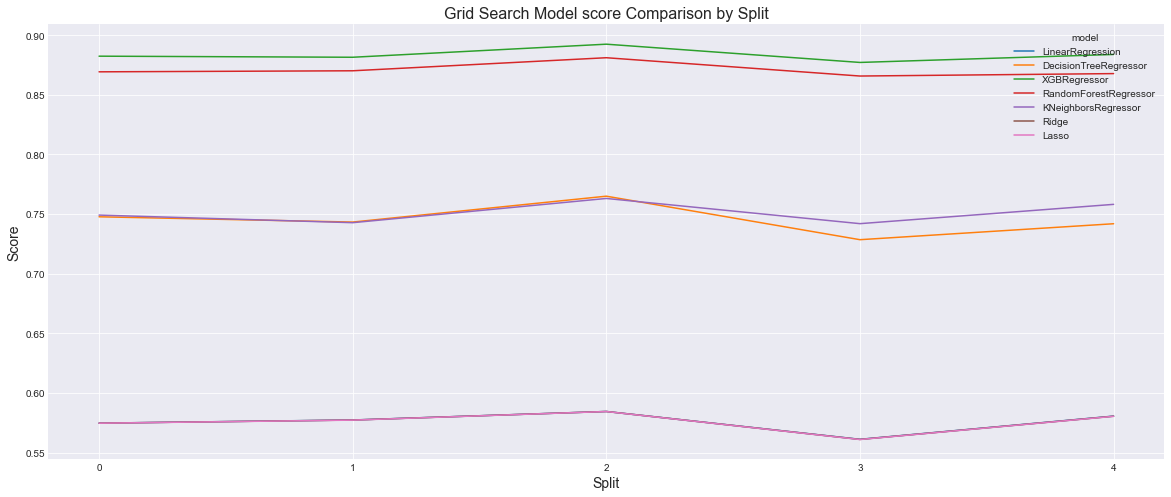

In [7]:
def get_split_scores(splits, grid_reg):
    scores = []
    models = []
    split_nums = []
    for i in range(splits):
        scores.append(grid_reg.cv_results_["split{}_test_score".format(i)][0])
        models.append(grid_reg.best_estimator_.__class__.__name__)
        split_nums.append(i)
    return split_nums, scores, models

splits = cv.cvargs["n_splits"]
fig, ax =plt.subplots(1,figsize=(20, 8))
plt.xticks(range(splits))
plt.xlabel("Split", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Grid Search Model score Comparison by Split", fontsize=16)
scores = []
models = []
split_nums = []
for reg in grid_result:
    t_split, t_scores, t_models = get_split_scores(splits, reg)
    scores = np.append(scores, t_scores)
    models = np.append(models, t_models)
    split_nums = np.append(split_nums, t_split)
result = pd.DataFrame()
result["split"] = split_nums
result["model"] = models
result["score"] = scores
g = sns.lineplot(x=result.split, y=result.score, hue=result.model)
plt.show

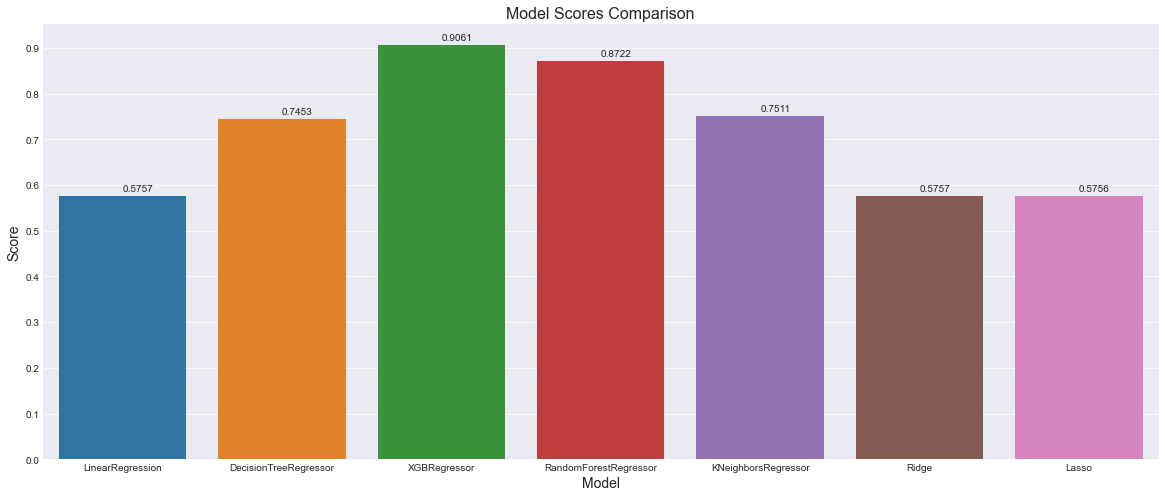

In [8]:
best_scores = [x.best_score_ for x in grid_result]
model_names = [x.best_estimator_.__class__.__name__ for x in grid_result]
fig, ax =plt.subplots(1,figsize=(20, 8))
g=sns.barplot(model_names, best_scores)
plt.title("Model Scores Comparison", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.yticks(np.arange(0.0, 1.0, 0.1))

for i in range(len(model_names)):
    g.text(i, best_scores[i]+0.01, "{:0.4f}".format(best_scores[i]))

plt.show()

### Train Selected model with All records

In [9]:
model = XGBRegressor(learning_rate= 0.1, max_depth= 10, n_estimators= 150, gpu_id=0, objective='reg:squarederror', random_state=random_state)
model.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=16, num_parallel_tree=1, random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Predict Target price for test dataset and Calculate Accuracy

In [10]:
prediction = model.predict(test_X)
sklearn.metrics.r2_score(test_Y, prediction)

0.9342159142918622

### Sample Prediction and actual price comparison

In [11]:
pred_df = pd.DataFrame()
pred_df["actual"] = test_Y.price
pred_df["predicted"] = prediction
x = [x for x in range(1, len(test_Y)+1)]
pred_df["index"] = x
pred_df.head(10)

,actual,predicted,index
69438,36999,35497.621094,1
319531,23995,23599.558594,2
448760,3200,3676.984131,3
389838,14990,14842.959961,4
73314,4900,7622.503418,5
185037,9995,12328.098633,6
294199,33590,33680.597656,7
237560,15600,20836.619141,8
27561,13977,12001.131836,9
25131,45000,45355.492188,10


### Plot comparing acutal and predicted value for 100 samples

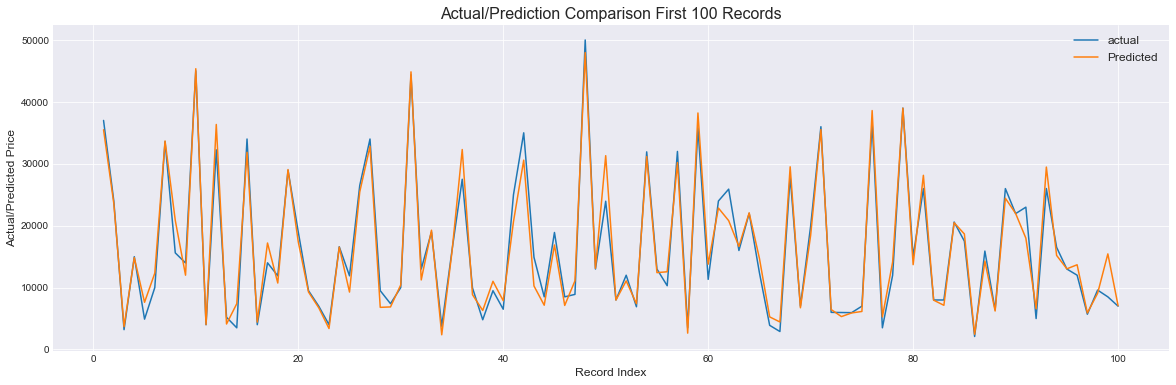

In [12]:
plt.figure(figsize=(20,6))
sns.lineplot(data=pred_df.head(100), x="index", y="actual")
sns.lineplot(data=pred_df.head(100), x="index", y="predicted")
plt.title("Actual/Prediction Comparison First 100 Records", fontsize=16)
plt.legend(["actual", "Predicted"], fontsize=12)
plt.ylabel("Actual/Predicted Price", fontsize=12)
plt.xlabel("Record Index", fontsize=12)
plt.show()